# Notebook to check custom accuracy metric for water delineation

Steps: 

1. Create and vectorize classification
    - load inference raster
    - filter and clean inference
    - vectorize
    - write to .shp file
2. load hand annotation
3. project classification and annotation to calculate metric and apply buffer
    - both inputs should be wgs84 epsg:4326
4. check recall and precision of classification result


In [151]:
# set parameters:
annotation_error = 0.0 # know geolocation error of annotation dataset
buffer_size = 4.5      # accuracy treshold in meters 
name = 'Cilegon_013'   # name of datasets to match

### file paths: 

# inference results
raster_files_path = '../../data/raster_classifications/classification_{}*.tif'.format(name)

# vectorized inference
prediction_file_path = '../../data/shapefiles_waterbodies_results/{}_result_shape.shp'.format(name)

# annotations
annotation_shapes_path = '../../data/hand_annotations_water/{}*.shp'.format(name)

# recalculate buffer zone by adding the annotation geolocation error
buffer_size = buffer_size - annotation_error 

## 1. Create and vectorize classification

In [152]:
from skimage import filters, morphology
from rasterio import features 
from shapely.geometry import shape
from shapely import geometry
import itertools

import numpy as np
import cv2 as cv

import matplotlib.pyplot as plt

import shapely.ops as ops
import random

import rasterio 
import glob

from pprint import pprint

from shapely.ops import cascaded_union

In [153]:
# helper functions

def wgs2epsg(x,y):
    EPSG = int(32700-round((45+y)/90,0)*100+round((183+x)/6,0))
    UTM_EPSG_code = EPSG
    
    return UTM_EPSG_code

# 
buffer_size = buffer_size - annotation_error 
def array_to_linestrings(array, mask, affine):
    
    if np.all(mask) == True:
        final_lines = []
    else:
        # Convert the array to polygon geometries
        polygon_generator = features.shapes(array.astype('uint8'), mask=array, transform=affine)
        # Extract out the individual polygons, fixing any invald geometries using buffer(0)
        polygons = [shape(g).buffer(0) for g,v in polygon_generator]

        # Next, build up a binary array representing the outer boundary of the input array
        boundary_array = np.ones(array.shape)    

        # Convert the boundary to a polygon too
        boundary_generator = features.shapes(boundary_array.astype('uint8'), transform=affine)
        boundary = [shape(g) for g,v in boundary_generator][0]

        # Convert the mask to a polygon too
        if mask is not None:
            
            mask_generator = features.shapes(mask.astype('uint8'), 
                                             mask= mask > 0,
                                             transform=affine)
            mask_boundary = [shape(g).buffer(0) for g,v in mask_generator][0]

        # Convert the array polygons to linestrings
        exterior_rings = [g.exterior for g in polygons]
        interior_rings = list(itertools.chain.from_iterable([[i for i in g.interiors] for g in polygons if len(g.interiors) > 0]))
        all_rings =  exterior_rings + interior_rings 

        # Erase both the image boundary and the mask boundary from the extracted Linestrings
        erased_lines = all_rings #[g.difference(boundary.exterior).difference(mask_boundary.exterior) for g in all_rings]
        singlepart_lines = [list(g) if type(g) == geometry.multilinestring.MultiLineString else [g] for g in erased_lines ]
        final_lines = list(itertools.chain(*singlepart_lines))

    return final_lines 

def check_valid_geometries(shapefile_path):
    
    shape_list = []

    for pol in fiona.open(shapefile_path):
        if pol['geometry'] != None:
#             if pol['geometry']['type'] == 'MultiPolygon':
#                 for sub_pol in pol['geometry']['coordinates']:
#                     pol = sub_pol[0]
#                     shape_list.append(pol)
#             else:
                shape_list.append(pol)
            
    return shape_list

In [154]:
# load classified rasters 

# find files in classification folder

raster_files = glob.glob(raster_files_path)
file_path = raster_files[0]

print(len(raster_files))
print('-------------------------------------')
pprint(raster_files)
print('-------------------------------------')
print(file_path)

data = rasterio.open(file_path).read()
dataset = rasterio.open(file_path)

left, bottom, right, top = dataset.bounds

affine = dataset.meta['transform']
width = dataset.meta['width']
height = dataset.meta['height']

1
-------------------------------------
['../../data/raster_classifications/classification_Cilegon_013_pansharpen_True_2016-08-06_03:21_1030010059856700.tif']
-------------------------------------
../../data/raster_classifications/classification_Cilegon_013_pansharpen_True_2016-08-06_03:21_1030010059856700.tif


## Filter and clean inference results

In [155]:
thresh = filters.threshold_otsu(data[0])
data_otsu_treshold = data[0] > thresh
water_data = data_otsu_treshold.astype('uint8')

# rescale values to 0 - 255 to use image processing algorithms
OldRange = (water_data.max() - water_data.min())  
NewRange = (0 - 255)  
NewValue = (((water_data - water_data.min()) * NewRange) / OldRange) + 0

water_data = NewValue.round().astype('uint8')
water_blurred = cv.medianBlur(water_data,3)

# Specify the minimum feature size in square meters, and then use info from the image metadata 
# to translate to grid cell count.

# Set the minimum feature size to 400 sq km (400,000 m)
min_feature_size_m2 = 500.

# From the image metadata, we can determine the area of a single grid cell
try: 
    cell_height_m = image.rda.metadata['image']['groundSampleDistanceMeters']
except: 
    cell_height_m = 0.40
    
cell_area_m2 = cell_height_m**2

# Finally, use the cell size to convert the minimum feature size to grid cells
min_feature_size_cells = np.round((min_feature_size_m2/cell_area_m2)).astype('int64')

# What is the minimum feature size in square meters and grid cells?
print(min_feature_size_m2, 'sq. m')
print(min_feature_size_cells, 'grid cells')

# scikit-image modules for image science operators
from skimage import filters, morphology

# First, remove the small holes
water_cleaned = morphology.remove_small_holes(water_blurred, min_feature_size_cells)

# Then remove the small objects
water_cleaned = morphology.remove_small_objects(water_cleaned, min_feature_size_cells, connectivity=2)

500.0 sq. m
3125 grid cells


/home/chris/anaconda3/envs/GISpy_1/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?


Text(0.5, 1.0, 'Cleaned Water Mask')

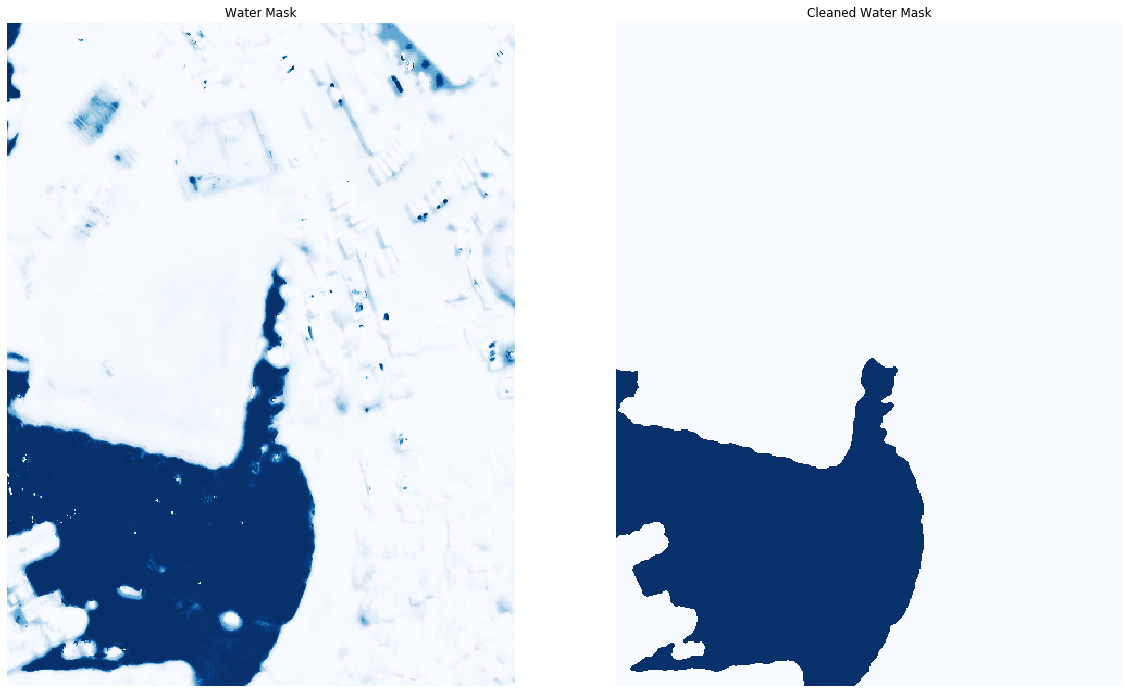

In [156]:
# # View the results
plt.figure(figsize=(20,15))
# plt.subplot(1, 3, 1)
# plt.axis('off')
# # plt.imshow(rgb)
# plt.title("RGB")

plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(data[0], vmin=0, vmax=1, cmap = 'Blues')
plt.title("Water Mask")

plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(water_cleaned, vmin=0, vmax=1, cmap = 'Blues')
plt.title("Cleaned Water Mask")

## Vectorize cleaned inference results

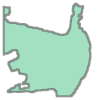

In [157]:
water_lines = array_to_linestrings(array = water_cleaned, mask = water_cleaned, affine = affine)

# Run a basic simplification algorithm to smooth the lines
water_lines_smooth = [g.simplify(0.001) for g in water_lines]

# GLue it all together
detection = cascaded_union(water_lines)

import shapely.ops as ops
import random
# setu_smooth = setu_wgs.simplify(0.00003)
detection_poly = ops.polygonize_full(detection)

detection_poly = cascaded_union(detection_poly)

buffer = 0# 1e-05

detection_poly_smooth = detection_poly.buffer(-buffer).buffer(buffer)

detection_poly_smooth

detection_poly = ops.polygonize_full(detection_poly_smooth)[0]

sample = random.randint(0,len(detection_poly)) - 1 


detection_poly

In [158]:
import ogr

prediction_file_path = '../../data/shapefiles_waterbodies_results/{}_result_shape.shp'.format(name)

your_shape = detection_poly

# Now convert it to a shapefile with OGR    
driver = ogr.GetDriverByName('Esri Shapefile')
ds = driver.CreateDataSource(prediction_file_path)
layer = ds.CreateLayer('', None, ogr.wkbPolygon)
# Add one attribute
layer.CreateField(ogr.FieldDefn('id', ogr.OFTInteger))
defn = layer.GetLayerDefn()

i = 0

## If there are multiple geometries, put the "for" loop here
for poly in your_shape:

    # Create a new feature (attribute and geometry)
    feat = ogr.Feature(defn)
    feat.SetField('id', i)
    # print(id_list[i])

    # Make a geometry, from Shapely object
    geom = ogr.CreateGeometryFromWkb(poly.wkb)
    feat.SetGeometry(geom)

    layer.CreateFeature(feat)
    feat = geom = None  # destroy these
    
    
    i = i + 1 
    

# Save and close everything
ds = layer = feat = geom = None

print('file written to: ', prediction_file_path)

file written to:  ../../data/shapefiles_waterbodies_results/Cilegon_013_result_shape.shp


## Load annotation

In [159]:
# find files in shapefile folder
annotation_shape_files = glob.glob(annotation_shapes_path)
annotation_file_path = annotation_shape_files[0]


# apply function to measure custom metric

In [160]:
from shapely.ops import transform
from shapely import ops
from functools import partial
import pyproj

from shapely.ops import cascaded_union
from shapely.affinity import translate
import fiona

def custom_metric_calculation(prediction_file_path, annotation_file_path, buffer_size):

    #### load data ##### 
    # convert esri shapefiles to shapely objects
    # check valid geometries
    prediction_valid_shape_list = check_valid_geometries(prediction_file_path)

    # convert list to shapely MultiPolgyons (in wgs84)
    prediction_wgs = cascaded_union([shape(pol['geometry']) for pol in prediction_valid_shape_list])
    
    # convert esri shapefiles to shapely objects
    # check valid geometries
    annotation_valid_shape_list = check_valid_geometries(annotation_file_path)

    # convert list to shapely MultiPolgyons (in wgs84)
    annotation_wgs = cascaded_union([shape(pol['geometry']) for pol in annotation_valid_shape_list])

    # check dataformat to apply conversion 
    if annotation_wgs.type == 'MultiLineString':
        annotation_wgs_exterior = cascaded_union([poly for poly in annotation_wgs])
    else: 
        annotation_wgs_exterior = cascaded_union([poly.exterior for poly in annotation_wgs])
        
        
        # check dataformat to apply conversion 
    if prediction_wgs.type == 'MultiLineString':
        prediction_wgs_exterior = cascaded_union([poly for poly in prediction_wgs])
    elif prediction_wgs.type == 'Polygon':
        prediction_wgs_exterior = prediction_wgs.exterior
    else: 
        prediction_wgs_exterior = cascaded_union([poly.exterior for poly in prediction_wgs])
    
    ### create projections
    
    # get vector projection 
    x,y  = prediction_wgs.centroid.xy

    epsg = wgs2epsg(x[0], y[0])

    #  EPSG:32748 is also known as WGS 84 / UTM zone 48S

    # set projections
    project_wgs2utm = partial(
        pyproj.transform,
        pyproj.Proj(init='epsg:4326'),
        pyproj.Proj(init='epsg:{}'.format(epsg)))

    project_utm2wgs = partial(
        pyproj.transform,
        pyproj.Proj(init='epsg:{}'.format(epsg)), # from
        pyproj.Proj(init='epsg:4326'))            # to


    ### apply offset
    
    # sometimes a correction for geolocation inaccuracies is needed
    x_offset =  0
    y_offset =  0
    prediction_wgs = translate(prediction_wgs,xoff = x_offset, yoff = y_offset, zoff=0.0)
    
    ### project and apply buffer 
    
    # transform input data to projected coordinate system
    prediction_utm = transform(project_wgs2utm, prediction_wgs)

    # create polygon by applying buffer zone and convert back to wgs84
    prediction_utm_buffer = prediction_utm.exterior.buffer(buffer_size)
    prediction_wgs_buffer_zone = transform(project_utm2wgs, prediction_utm_buffer)

    # get all necessary shapes
    annotation_utm_exterior = transform(project_wgs2utm, annotation_wgs_exterior)
    annotation_utm_buffer_zone = annotation_utm_exterior.buffer(buffer_size)
    annotation_wgs_buffer_zone = transform(project_utm2wgs, annotation_utm_buffer_zone)

    ### calculate metrics
    
    # calculate Recall 
    total_length_annotation = annotation_wgs_exterior.length
    length_overlap_prediction_annotation = prediction_wgs_buffer_zone.intersection(annotation_wgs_exterior).length
    Recall = round( length_overlap_prediction_annotation / total_length_annotation,3)

    # calculate Precision
    total_length_prediction = prediction_wgs.length
    length_overlap_detection_annotation = annotation_wgs_buffer_zone.intersection(prediction_wgs_exterior).length
    Precision = round( length_overlap_detection_annotation / total_length_prediction,3)
    
    return Precision, Recall,annotation_wgs_exterior, length_overlap_detection_annotation / total_length_prediction

In [161]:
Precision, Recall, annotation_wgs_exterior, prediction_utm = custom_metric_calculation(prediction_file_path, annotation_file_path, buffer_size)

print('Recall    @ {}m is {}%'.format(buffer_size, round(Recall * 100,3)))
print('Precision @ {}m is {}%'.format(buffer_size, round(Precision * 100,3)))

Recall    @ 4.5m is 82.9%
Precision @ 4.5m is 84.3%
